# Livrable 2 - Denoising d'images

|Auteurs|
|---|
|Frédéric SPATARO|
|Oscar PALISSOT|
|Djayan DEMAISON|
|Arnaud HITTINGER|
|Nicolas PELLEGRINI|

# 1. Introduction

## 1.1. Présentation du problème de débruitage d'image

Le débruitage d'images, ou denoising, est une étape cruciale dans le prétraitement des données, en particulier dans le contexte des données numérisées. Les images numérisées, en particulier celles qui proviennent de documents papier, peuvent présenter divers degrés de bruit sous forme de points, de stries ou d'autres artefacts visuels qui peuvent potentiellement interférer avec les analyses ultérieures, telles que la classification ou la génération de légendes. Le débruitage est donc essentiel pour assurer la précision et la fiabilité des modèles de machine learning qui seront appliqués par la suite.

## 1.2. Objectifs du Notebook

L'objectif de ce notebook est de mettre en œuvre une solution de débruitage d'images en utilisant des auto-encodeurs convolutifs. Nous chercherons à :

- Préparer les données d'images pour l'entraînement du modèle.
- Construire et entraîner un auto-encodeur convolutif pour le débruitage d'images.
- Évaluer les performances du modèle et visualiser les résultats.
- Fournir une analyse critique des résultats et identifier les domaines potentiels d'amélioration.

## 1.3. Briève introduction aux auto-encodeurs

Les auto-encodeurs sont un type de réseau de neurones utilisé pour l'apprentissage non supervisé. Ils visent à apprendre une représentation (encodage) efficace des données, généralement dans le but de réduire la dimensionnalité. Un auto-encodeur est structuré en deux parties principales :

- Encodeur: Il apprend à compresser l'entrée dans une forme latente, souvent de dimensionnalité réduite.
- Décodeur: Il apprend à reconstruire l'entrée à partir de cette forme latente.

Dans le contexte du débruitage d'images, les auto-encodeurs sont entraînés pour mapper des images bruitées à leurs versions propres, en apprenant à supprimer le bruit tout en conservant les caractéristiques importantes des données.

# 2. Importation et exploration des données

## 2.1. Importation des bibliothèques nécessaires

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt

#2
from keras.preprocessing import image
#3
from sklearn.model_selection import train_test_split
#4
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
#6
from skimage.metrics import peak_signal_noise_ratio as psnr

print("Import terminé.")

Import terminé.


## 2.2. Chargement du dataset d'images

In [26]:
data_dir = 'DataL2'
image_files = os.listdir(data_dir)

# Paramètres des images
img_height, img_width, rgb = 256, 256, 3
images = []

for img_file in image_files:
    img_path = os.path.join(data_dir, img_file)
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    images.append(img_array)

images = np.array(images)

print("Chargement terminé.")

Chargement terminé.


## 2.3. Exploration des données

In [27]:
# Afficher quelques informations de base sur les données
print(f"Nombre total d'images : {images.shape[0]}")
print(f"Dimensions des images : {images.shape[1:]}")
print(f"Valeur min des pixels : {np.min(images)}")
print(f"Valeur max des pixels : {np.max(images)}")

print("\nExploration terminé.")

Nombre total d'images : 148
Dimensions des images : (256, 256, 3)
Valeur min des pixels : 0.0
Valeur max des pixels : 255.0

Exploration terminé.


## 2.4. Visualisation d'exemples d'images

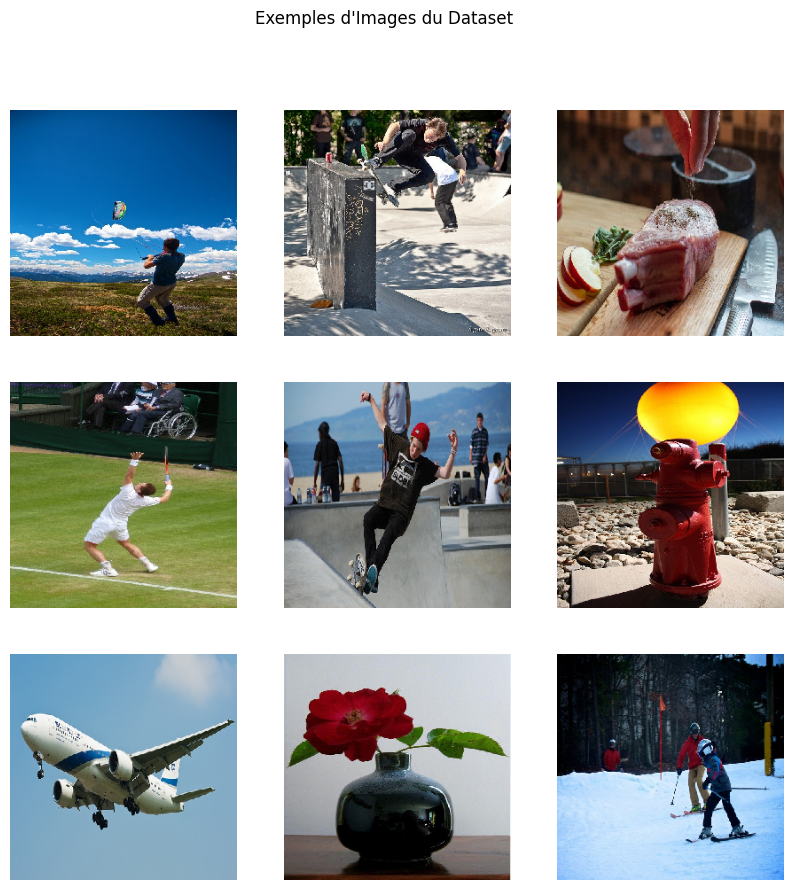

Visualisation terminé.


In [28]:
# Afficher quelques images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].astype('uint8'))
    plt.axis('off')
plt.suptitle('Exemples d\'Images du Dataset')
plt.show()

print("Visualisation terminé.")

## 2.5. Distribution des valeurs de pixel

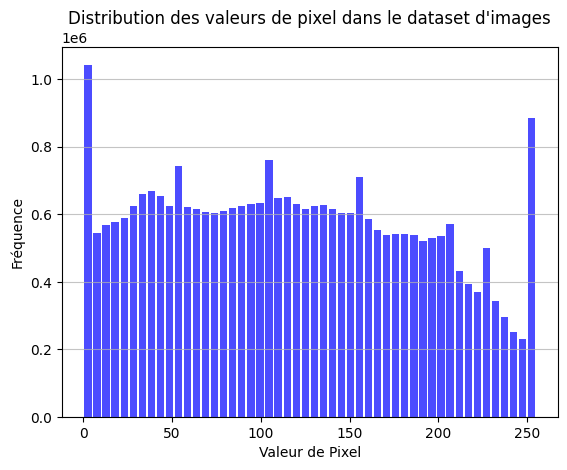

La valeur moyenne des pixels est: 117.62
L'écart-type des valeurs de pixel est: 71.52
Visualisation terminée.


In [29]:
# Calculer la distribution des valeurs de pixel
pixel_values = images.flatten()
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7, rwidth=0.8)
plt.title('Distribution des valeurs de pixel dans le dataset d\'images')
plt.xlabel('Valeur de Pixel')
plt.ylabel('Fréquence')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Calculer et afficher la moyenne et l'écart-type des valeurs de pixel
mean_pixel_value = np.mean(pixel_values)
std_pixel_value = np.std(pixel_values)
print(f"La valeur moyenne des pixels est: {mean_pixel_value:.2f}")
print(f"L'écart-type des valeurs de pixel est: {std_pixel_value:.2f}")

print("Visualisation terminée.")

* Moyenne des pixels :

La valeur moyenne des pixels de 117.62 suggère que, sur une échelle de 0 (noir) à 255 (blanc), nos images tendent à être d'une luminosité modérée à élevée. Cela pourrait signifier que nos images sont relativement claires, mais avec une présence notable de zones plus sombres puisque la moyenne n'est pas extrêmement élevée.

* Écart-Type des Pixels : 

Un écart-type de 71.57 indique une assez grande variabilité dans les valeurs des pixels à travers l'ensemble des images. Cela signifie que bien que la moyenne des valeurs de pixel soit relativement élevée, il y a une quantité significative de pixels qui sont soit beaucoup plus clairs, soit beaucoup plus sombres que la moyenne.

# 3. Préparation des données

## 3.1. Normalisation des images

On divise toutes les valeurs de pixels par 255, ce qui transforme les valeurs de pixel originales de la plage [0, 255] à [0, 1]. Cette étape permet de modérer les poids et gradients lors de l'entraînement du réseau de neurones, facilitant ainsi la convergence du modèle et améliorant la stabilité du processus d'apprentissage.

In [30]:
# Normaliser les images pour que les valeurs de pixel soient dans [0, 1]
normalized_images = images / 255.0

print("Normalisation terminé.")

Normalisation terminé.


## 3.2. Bruitage artificiel des images

On introduit un bruit artificiel dans les données d'entraînement pour forcer le modèle à apprendre à reconstruire l'image originale à partir de sa version bruitée. 

On a choisi une `noise_factor` de `0.15` après une série d'expérimentations et d'observations. Ce niveau de bruit est suffisant pour introduire un défi pour l'auto-encodeur tout en préservant les caractéristiques clés des images pour que le modèle puisse apprendre efficacement à les reconstruire. 

In [31]:
# Paramètres pour l'ajout de bruit
noise_factor = 0.00

# Ajout de bruit gaussien aux images
noisy_images = normalized_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images = np.clip(noisy_images, 0., 1.)

print("Bruitage terminé.")

Bruitage terminé.


## 3.3. Division en série d'entraînement et de test

On a opté pour une répartition de 80% des données pour l'entraînement et 20% pour le test.

In [32]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    noisy_images,  # les images bruitées -> entrées
    normalized_images,  # les images originales -> cibles
    test_size=0.2,
    random_state=42
)

print("Division en test/train terminé.")

Division en test/train terminé.


## 3.4. Visualisation des images bruitées

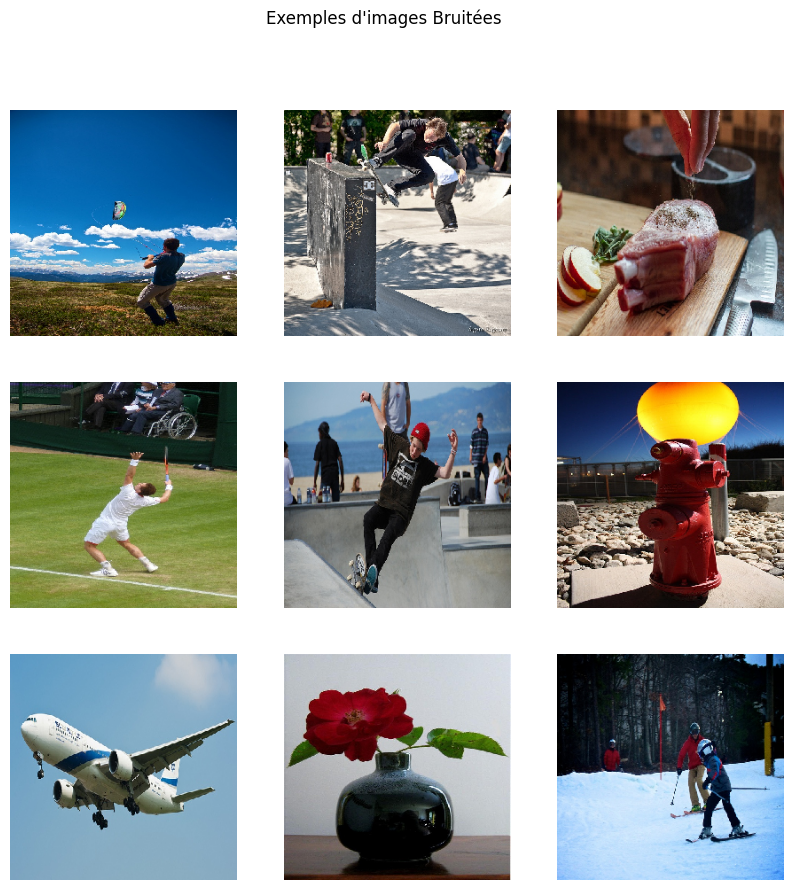

Visualisation terminé.


In [33]:
# Afficher quelques images bruitées
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(noisy_images[i].astype('float32'))
    plt.axis('off')
plt.suptitle('Exemples d\'images Bruitées')
plt.show()

print("Visualisation terminé.")

# 4. Construction de l'auto-encodeur convolutif

In [34]:
# Définition des images
input_img = Input(shape=(img_height, img_width, rgb))

print("Paramètres appliqués.")

Paramètres appliqués.


## 4.1. Architecture de l'encodeur

On utilise ici une série de couches convolutives et de pooling pour progressivement réduire la dimensionnalité de l'entrée. Les couches convolutives extraient les caractéristiques spatiales des images, tandis que les couches de pooling réduisent les dimensions spatiales (hauteur et largeur), compactant ainsi l'information.

In [35]:
# Paramètres de l'encodeur
encoder_params = [
    {"filters": 64, "kernel_size": (3, 3), "activation": 'relu', "padding": 'same'},
    {"pool_size": (2, 2), "padding": 'same'},
    {"filters": 128, "kernel_size": (3, 3), "activation": 'relu', "padding": 'same'},
    {"pool_size": (2, 2), "padding": 'same'}
]

# Encodeur
x = input_img
for i in range(0, len(encoder_params), 2):
    x = Conv2D(**encoder_params[i])(x)
    x = MaxPooling2D(**encoder_params[i+1])(x)
encoded = x

print("Encodeur paramétré.")

Encodeur paramétré.


## 4.2. Architecture du décodeur

On cherche à reconstruire l'image d'origine via un série de couches convolutives et d'opérations d'upsampling. Les couches convolutives dans le décodeur servent à générer de nouvelles caractéristiques à partir de l'espace latent, tandis que les couches d'upsampling augmentent progressivement la hauteur et la largeur des volumes de sortie. 

In [36]:
# Paramètres du décodeur
decoder_params = [
    {"filters": 128, "kernel_size": (3, 3), "activation": 'relu', "padding": 'same'},
    {"size": (2, 2)},
    {"filters": 64, "kernel_size": (3, 3), "activation": 'relu', "padding": 'same'},
    {"size": (2, 2)},
    {"filters": rgb, "kernel_size": (3, 3), "activation": 'sigmoid', "padding": 'same'}
]

# Décodeur
for i in range(0, len(decoder_params)-1, 2):
    x = Conv2D(**decoder_params[i])(x)
    x = UpSampling2D(**decoder_params[i+1])(x)
x = Conv2D(**decoder_params[-1])(x)
decoded = x

print("Décodeur paramétré.")

Décodeur paramétré.


## 4.3. Modèle d'auto-encodeur complet

In [37]:
# Construction du modèle d'auto-encodeur complet
autoencoder = Model(input_img, decoded)
autoencoder.summary()

# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       1475

# 5. Entraînement du modèle

## 5.1. Définition des hyperparamètres

In [38]:
epochs = 200
batch_size = 4

print("Hyperparamètres définis.")

Hyperparamètres définis.


## 5.2. Entraînement de l'auto-encodeur

In [39]:
history = autoencoder.fit(
    X_train,  # images bruitées
    y_train,  # images originales
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test, y_test),
)

print("Auto-encodeur entraîné.")

Epoch 1/200
30/30 [==============================] - 3s 49ms/step - loss: 0.6319 - val_loss: 0.5920
Epoch 2/200
30/30 [==============================] - 1s 40ms/step - loss: 0.5582 - val_loss: 0.5474
Epoch 3/200
30/30 [==============================] - 1s 41ms/step - loss: 0.5371 - val_loss: 0.5404
Epoch 4/200
30/30 [==============================] - 1s 39ms/step - loss: 0.5338 - val_loss: 0.5384
Epoch 5/200
30/30 [==============================] - 1s 39ms/step - loss: 0.5324 - val_loss: 0.5373
Epoch 6/200
30/30 [==============================] - 1s 39ms/step - loss: 0.5315 - val_loss: 0.5362
Epoch 7/200
30/30 [==============================] - 1s 39ms/step - loss: 0.5284 - val_loss: 0.5355
Epoch 8/200
30/30 [==============================] - 1s 39ms/step - loss: 0.5290 - val_loss: 0.5349
Epoch 9/200
30/30 [==============================] - 1s 39ms/step - loss: 0.5270 - val_loss: 0.5332
Epoch 10/200
30/30 [==============================] - 1s 40ms/step - loss: 0.5263 - val_loss: 0.5327

## 5.3. Visualisation de la loss durant l'entraînement

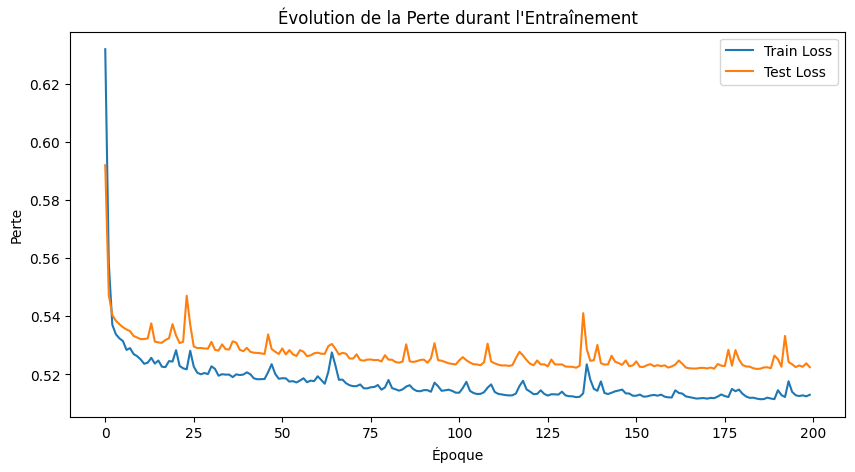

Loss visualisé.


In [40]:
# Tracer l'historique de la perte durant l'entraînement
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Évolution de la Perte durant l\'Entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.show()

print("Loss visualisé.")

# 6. Évaluation du modèle

## 6.1. Évaluation quantitative du modèle sur l'ensemble de test

In [41]:
# Prédiction des images débruitées à partir des images bruitées de test
decoded_imgs = autoencoder.predict(X_test)

# Initialisation des métriques
psnr_vals = []

# Boucle sur les images pour calculer PSNR
for orig, pred in zip(y_test, decoded_imgs):
    orig = orig.astype("float32")
    pred = pred.astype("float32")
    
    # Calcul et stockage du PSNR pour chaque paire d'images
    psnr_vals.append(psnr(orig, pred, data_range=orig.max() - orig.min()))

# Calcul de la moyenne du PSNR
mean_psnr = np.mean(psnr_vals)

# Affichage du PSNR moyen
print(f"Mean PSNR: {mean_psnr:.2f}")

1/1 [==============================] - 0s 83ms/step
Mean PSNR: 26.91


## 6.2. Visualisation des images débruitées

In [42]:
# Prédiction des images débruitées à partir des images bruitées
decoded_imgs = autoencoder.predict(X_test)

# Affichage des images originales, bruitées et débruitées
plt.figure(figsize=(300, 140))
num_images_to_show = 6

for i in range(num_images_to_show):
    # Images originales
    ax = plt.subplot(3, num_images_to_show, i + 1)
    plt.imshow(y_test[i].reshape(img_height, img_width, rgb))
    plt.title("Original")
    plt.axis("off")
    
    # Images bruitées
    ax = plt.subplot(3, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(X_test[i].reshape(img_height, img_width, rgb))
    plt.title("Noisy")
    plt.axis("off")
    
    # Images débruitées générées par l'auto-encodeur
    ax = plt.subplot(3, num_images_to_show, i + 1 + 2*num_images_to_show)
    plt.imshow(decoded_imgs[i].reshape(img_height, img_width, rgb))
    plt.title("Denoised")
    plt.axis("off")

plt.suptitle("Image Reconstruction by Autoencoder")
plt.show()

1/1 [==============================] - 0s 21ms/step
